In [1]:
# VIX Feature Diagnostics - Execute in Jupyter Lab from /src
# This cell contains the complete diagnostic suite

import json,sqlite3,warnings
from collections import defaultdict
from datetime import datetime,timedelta
from pathlib import Path
import numpy as np,pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None);pd.set_option('display.max_rows',100);pd.set_option('display.width',None)
from config import ENSEMBLE_CONFIG
act_thres = .58
class FeatureDiagnostics:
    def __init__(self,feature_data_path='data_cache',db_path='data_cache/predictions.db'):
        self.feature_data_path=Path(feature_data_path);self.db_path=Path(db_path);self.results={};self.features_df=None;self.mag_importance={};self.dir_importance={}
    def load_feature_importance(self,mag_path='data_cache/feature_importance_magnitude.json',dir_path='data_cache/feature_importance_direction.json'):
        print("="*80);print("LOADING FEATURE IMPORTANCE SCORES");print("="*80)
        if Path(mag_path).exists():
            with open(mag_path)as f:self.mag_importance=json.load(f)
            print(f"✓ Loaded {len(self.mag_importance)} magnitude importance scores")
        else:print(f"⚠ Magnitude importance not found at {mag_path}")
        if Path(dir_path).exists():
            with open(dir_path)as f:self.dir_importance=json.load(f)
            print(f"✓ Loaded {len(self.dir_importance)} direction importance scores")
        else:print(f"⚠ Direction importance not found at {dir_path}")
        print()
    def load_latest_features(self):
        print("="*80);print("LOADING FEATURE DATA");print("="*80)
        from core.data_fetcher import UnifiedDataFetcher
        from core.feature_engineer import FeatureEngineer
        fetcher=UnifiedDataFetcher();engineer=FeatureEngineer(data_fetcher=fetcher);yesterday=(datetime.now()-timedelta(days=1)).strftime("%Y-%m-%d");print(f"Building features through {yesterday}...");feature_data=engineer.build_complete_features(years=20,end_date=yesterday,force_historical=False);self.features_df=feature_data['features'];print(f"✓ Loaded {len(self.features_df)} rows × {len(self.features_df.columns)} features");print(f"  Date range: {self.features_df.index[0].date()} → {self.features_df.index[-1].date()}");print();return self.features_df
    def analyze_feature_quality(self):
        print("="*80);print("ANALYZING FEATURE QUALITY");print("="*80);exclude_cols={'vix','spx','calendar_cohort','cohort_weight','feature_quality','spx_lag1'};feature_cols=[c for c in self.features_df.columns if c not in exclude_cols];analysis=[]
        for feat in feature_cols:
            series=self.features_df[feat];total=len(series);valid=series.notna().sum();coverage=(valid/total)*100;nans=series.isna().sum();nan_pct=(nans/total)*100;infs=(np.isinf(series)).sum();inf_pct=(infs/total)*100;zeros=(series==0).sum();zero_pct=(zeros/total)*100;valid_data=series.dropna()
            if len(valid_data)>0:
                unique_vals=valid_data.nunique();unique_pct=(unique_vals/len(valid_data))*100
                # FIX: Convert to float64 before quantile operations to avoid boolean dtype issues
                try:
                    valid_numeric=valid_data.astype(np.float64)
                    val_min=float(valid_numeric.min());val_max=float(valid_numeric.max());val_mean=float(valid_numeric.mean());val_std=float(valid_numeric.std());val_median=float(valid_numeric.median());q25=float(valid_numeric.quantile(0.25));q75=float(valid_numeric.quantile(0.75));iqr=q75-q25;lower_outliers=(valid_numeric<(q25-1.5*iqr)).sum();upper_outliers=(valid_numeric>(q75+1.5*iqr)).sum();outlier_pct=((lower_outliers+upper_outliers)/len(valid_numeric))*100
                    if val_std>0:cv=abs(val_std/val_mean)if val_mean!=0 else np.inf
                    else:cv=0
                except (TypeError, ValueError) as e:
                    # Handle non-numeric columns gracefully
                    val_min=val_max=val_mean=val_std=val_median=q25=q75=np.nan;outlier_pct=0;cv=np.nan
            else:unique_vals=0;unique_pct=0;val_min=np.nan;val_max=np.nan;val_mean=np.nan;val_std=np.nan;val_median=np.nan;outlier_pct=0;cv=np.nan
            mag_imp=self.mag_importance.get(feat,0)*1000;dir_imp=self.dir_importance.get(feat,0)*1000;avg_imp=(mag_imp+dir_imp)/2;imp_rank='NONE'
            if avg_imp>5:imp_rank='HIGH'
            elif avg_imp>2:imp_rank='MEDIUM'
            elif avg_imp>0.1:imp_rank='LOW'
            quality_flag='GOOD';issues=[]
            if coverage<50:quality_flag='CRITICAL';issues.append('LOW_COVERAGE')
            elif coverage<80:quality_flag='POOR';issues.append('MEDIUM_COVERAGE')
            if nan_pct>30:issues.append('HIGH_NAN')
            if inf_pct>1:issues.append('INFINITIES')
            if zero_pct>50:issues.append('HIGH_ZEROS')
            if unique_pct<1:issues.append('LOW_VARIANCE')
            if outlier_pct>10:issues.append('HIGH_OUTLIERS')
            if cv>10:issues.append('HIGH_VOLATILITY')
            if len(issues)>0 and quality_flag=='GOOD':quality_flag='FAIR'
            analysis.append({'feature':feat,'coverage_pct':round(coverage,2),'valid_count':valid,'nan_count':nans,'nan_pct':round(nan_pct,2),'inf_count':infs,'inf_pct':round(inf_pct,4),'zero_count':zeros,'zero_pct':round(zero_pct,2),'unique_values':unique_vals,'unique_pct':round(unique_pct,2),'min':round(val_min,4)if not np.isnan(val_min)else None,'max':round(val_max,4)if not np.isnan(val_max)else None,'mean':round(val_mean,4)if not np.isnan(val_mean)else None,'std':round(val_std,4)if not np.isnan(val_std)else None,'median':round(val_median,4)if not np.isnan(val_median)else None,'q25':round(q25,4)if not np.isnan(q25)else None,'q75':round(q75,4)if not np.isnan(q75)else None,'outlier_pct':round(outlier_pct,2),'coeff_variation':round(cv,4)if not np.isnan(cv)and np.isfinite(cv)else None,'mag_importance':round(mag_imp,4),'dir_importance':round(dir_imp,4),'avg_importance':round(avg_imp,4),'importance_rank':imp_rank,'quality_flag':quality_flag,'issues':'|'.join(issues)if issues else'NONE'})
        self.results['feature_analysis']=pd.DataFrame(analysis);print(f"✓ Analyzed {len(analysis)} features");print(f"  Quality distribution:")
        for qf in['GOOD','FAIR','POOR','CRITICAL']:count=(self.results['feature_analysis']['quality_flag']==qf).sum();print(f"    {qf:10s}: {count:3d}")
        print();return self.results['feature_analysis']
    def identify_problem_features(self):
        print("="*80);print("PROBLEM FEATURE CATEGORIZATION");print("="*80);fa=self.results['feature_analysis'];critical=fa[fa['quality_flag']=='CRITICAL'].sort_values('avg_importance',ascending=False);print(f"\n🔴 CRITICAL ISSUES ({len(critical)} features):");print(f"   Low coverage (<50%) - likely data pipeline problems")
        if len(critical)>0:
            for _,row in critical.head(10).iterrows():print(f"   • {row['feature']:40s} {row['coverage_pct']:5.1f}% coverage | Importance: {row['importance_rank']}")
        poor=fa[fa['quality_flag']=='POOR'].sort_values('avg_importance',ascending=False);print(f"\n🟡 POOR QUALITY ({len(poor)} features):")
        if len(poor)>0:
            for _,row in poor.head(10).iterrows():print(f"   • {row['feature']:40s} {row['coverage_pct']:5.1f}% coverage | Issues: {row['issues']}")
        high_imp_low_cov=fa[(fa['avg_importance']>2)&(fa['coverage_pct']<90)].sort_values('avg_importance',ascending=False);print(f"\n⚠️  HIGH IMPORTANCE + LOW COVERAGE ({len(high_imp_low_cov)} features):");print(f"   These are valuable but need data quality fixes")
        if len(high_imp_low_cov)>0:
            for _,row in high_imp_low_cov.head(10).iterrows():print(f"   • {row['feature']:40s} Imp={row['avg_importance']:6.3f} | Cov={row['coverage_pct']:5.1f}%")
        no_data_no_imp=fa[(fa['coverage_pct']<20)&(fa['avg_importance']<0.1)];print(f"\n💀 NO DATA + NO IMPORTANCE ({len(no_data_no_imp)} features):");print(f"   Deprecation candidates - neither data nor predictive value")
        if len(no_data_no_imp)>0:
            for _,row in no_data_no_imp.head(10).iterrows():print(f"   • {row['feature']:40s} Cov={row['coverage_pct']:5.1f}%")
        self.results['critical_features']=critical;self.results['poor_features']=poor;self.results['high_imp_low_cov']=high_imp_low_cov;self.results['deprecation_candidates']=no_data_no_imp;print()
    def analyze_feature_importance_patterns(self):
        print("="*80);print("FEATURE IMPORTANCE PATTERNS");print("="*80);fa=self.results['feature_analysis'];top_mag=fa.nlargest(20,'mag_importance')[['feature','mag_importance','coverage_pct','quality_flag']];top_dir=fa.nlargest(20,'dir_importance')[['feature','dir_importance','coverage_pct','quality_flag']];print("\n🎯 TOP 20 MAGNITUDE FEATURES:")
        for _,row in top_mag.iterrows():print(f"   {row['feature']:40s} {row['mag_importance']:7.4f} | Cov={row['coverage_pct']:5.1f}% | {row['quality_flag']}")
        print("\n🎯 TOP 20 DIRECTION FEATURES:")
        for _,row in top_dir.iterrows():print(f"   {row['feature']:40s} {row['dir_importance']:7.4f} | Cov={row['coverage_pct']:5.1f}% | {row['quality_flag']}")
        both_high=fa[(fa['mag_importance']>3)&(fa['dir_importance']>3)].sort_values('avg_importance',ascending=False);print(f"\n⭐ HIGH ON BOTH MODELS ({len(both_high)} features):");print("   Universal predictors - consider interactions/derivatives")
        if len(both_high)>0:
            for _,row in both_high.head(15).iterrows():print(f"   • {row['feature']:40s} Mag={row['mag_importance']:6.3f} Dir={row['dir_importance']:6.3f}")
        mag_only=fa[(fa['mag_importance']>3)&(fa['dir_importance']<1)];dir_only=fa[(fa['dir_importance']>3)&(fa['mag_importance']<1)];print(f"\n📊 MAGNITUDE-SPECIFIC ({len(mag_only)} features):")
        if len(mag_only)>0:
            for _,row in mag_only.head(10).iterrows():print(f"   • {row['feature']:40s} Mag={row['mag_importance']:6.3f}")
        print(f"\n📊 DIRECTION-SPECIFIC ({len(dir_only)} features):")
        if len(dir_only)>0:
            for _,row in dir_only.head(10).iterrows():print(f"   • {row['feature']:40s} Dir={row['dir_importance']:6.3f}")
        self.results['top_magnitude']=top_mag;self.results['top_direction']=top_dir;self.results['high_on_both']=both_high;self.results['magnitude_specific']=mag_only;self.results['direction_specific']=dir_only;print()
    def analyze_feature_distributions(self):
        print("="*80);print("DISTRIBUTION ANALYSIS");print("="*80);fa=self.results['feature_analysis'];high_skew=fa[fa['coeff_variation']>5].sort_values('coeff_variation',ascending=False);print(f"\n📈 HIGH VARIABILITY FEATURES ({len(high_skew)}):");print("   Candidates for log transformation or normalization")
        if len(high_skew)>0:
            for _,row in high_skew.head(10).iterrows():print(f"   • {row['feature']:40s} CV={row['coeff_variation']:8.2f} | Imp={row['avg_importance']:6.3f}")
        low_variance=fa[(fa['unique_pct']<5)&(fa['coverage_pct']>90)];print(f"\n🔒 LOW VARIANCE FEATURES ({len(low_variance)}):");print("   Candidates for binarization or binning")
        if len(low_variance)>0:
            for _,row in low_variance.head(10).iterrows():print(f"   • {row['feature']:40s} Unique={row['unique_pct']:5.2f}% | Values={row['unique_values']}")
        self.results['high_variability']=high_skew;self.results['low_variance']=low_variance;print()
    def query_actionable_signals(self):
        print("="*80);print("ACTIONABLE SIGNAL ANALYSIS");print("="*80)
        if not self.db_path.exists():print(f"⚠️  Database not found at {self.db_path}");return None
        conn=sqlite3.connect(self.db_path);query="SELECT forecast_date,observation_date,calendar_cohort,direction_prediction,direction_probability,magnitude_forecast,expected_vix,current_vix,feature_quality,actual_vix_change,direction_correct,magnitude_error FROM forecasts WHERE 1=1 ORDER BY forecast_date DESC";all_preds=pd.read_sql_query(query,conn);all_preds['ensemble_confidence']=all_preds['direction_probability'].apply(lambda x:max(x,1-x)if pd.notna(x)else np.nan);all_preds['actionable']=(all_preds['ensemble_confidence']>=act_thres);actionable=all_preds[all_preds['actionable']==True];print(f"\n📊 SIGNAL OVERVIEW:");print(f"   Total predictions: {len(all_preds)}");print(f"   Actionable: (≥{act_thres} confidence): {len(actionable)} ({len(actionable)/len(all_preds)*100:.1f}%)")
        if len(actionable)>0:
            print(f"\n🎯 ACTIONABLE SIGNAL BREAKDOWN:");print(f"   By Direction:")
            for dir in['UP','DOWN']:count=(actionable['direction_prediction']==dir).sum();print(f"      {dir:4s}: {count:4d} ({count/len(actionable)*100:.1f}%)")
            print(f"\n   By Cohort:")
            for cohort in actionable['calendar_cohort'].value_counts().head(4).index:count=(actionable['calendar_cohort']==cohort).sum();print(f"      {cohort:15s}: {count:4d}")
            print(f"\n   Confidence Distribution:");bins=[0.60,0.65,0.70,0.75,1.0];labels=['60-65%','65-70%','70-75%','75-100%'];actionable['conf_bucket']=pd.cut(actionable['ensemble_confidence'],bins=bins,labels=labels)
            for bucket in labels:count=(actionable['conf_bucket']==bucket).sum();print(f"      {bucket:10s}: {count:4d}")
        with_actuals=all_preds[all_preds['actual_vix_change'].notna()];actionable_actual=with_actuals[with_actuals['actionable']==True]
        if len(actionable_actual)>0:
            print(f"\n✅ ACTIONABLE SIGNAL PERFORMANCE:");print(f"   Signals with actuals: {len(actionable_actual)}");dir_acc=(actionable_actual['direction_correct']==1).sum()/len(actionable_actual);print(f"   Direction accuracy: {dir_acc:.1%}");mag_mae=actionable_actual['magnitude_error'].mean();print(f"   Magnitude MAE: {mag_mae:.2f}%");up_signals=actionable_actual[actionable_actual['direction_prediction']=='UP'];down_signals=actionable_actual[actionable_actual['direction_prediction']=='DOWN']
            if len(up_signals)>0:up_acc=(up_signals['direction_correct']==1).sum()/len(up_signals);print(f"   UP signals accuracy: {up_acc:.1%} ({len(up_signals)} signals)")
            if len(down_signals)>0:down_acc=(down_signals['direction_correct']==1).sum()/len(down_signals);print(f"   DOWN signals accuracy: {down_acc:.1%} ({len(down_signals)} signals)")
        conn.close();self.results['all_predictions']=all_preds;self.results['actionable_signals']=actionable;self.results['actionable_with_actuals']=actionable_actual if len(actionable_actual)>0 else None;print()
    def generate_feature_interaction_candidates(self):
        print("="*80);print("FEATURE INTERACTION OPPORTUNITIES");print("="*80);fa=self.results['feature_analysis'];high_importance=fa[fa['avg_importance']>3].sort_values('avg_importance',ascending=False);vix_features=[f for f in high_importance['feature']if'vix'in f.lower()];spx_features=[f for f in high_importance['feature']if'spx'in f.lower()];regime_features=[f for f in high_importance['feature']if'regime'in f.lower()];vol_features=[f for f in high_importance['feature']if'vol'in f.lower()and'vix'not in f.lower()];print(f"\n🔗 POTENTIAL INTERACTION PAIRS:");print(f"\n   VIX × SPX Interactions:")
        for vf in vix_features[:5]:
            for sf in spx_features[:3]:print(f"      • {vf} × {sf}");print(f"        → ratio: {vf}_over_{sf}");print(f"        → spread: {vf}_minus_{sf}")
        print(f"\n   Regime-Conditional Features:")
        for rf in regime_features[:3]:
            for hf in high_importance['feature'][:5]:
                if'regime'not in hf:print(f"      • {hf} | conditioned_on | {rf}")
        print(f"\n   Volatility Cross-Products:")
        if len(vol_features)>1:
            for i,vf1 in enumerate(vol_features[:4]):
                for vf2 in vol_features[i+1:5]:print(f"      • {vf1} × {vf2}")
        interactions={'vix_spx_pairs':[(v,s)for v in vix_features[:5]for s in spx_features[:3]],'regime_conditionals':[(r,h)for r in regime_features[:3]for h in high_importance['feature'][:5]if'regime'not in h],'vol_cross_products':[(vol_features[i],vol_features[j])for i in range(min(4,len(vol_features)))for j in range(i+1,min(5,len(vol_features)))]};self.results['interaction_candidates']=interactions;print()
    def save_results(self,output_dir='diagnostics'):
        print("="*80);print("SAVING RESULTS");print("="*80);out=Path(output_dir);out.mkdir(exist_ok=True);timestamp=datetime.now().strftime("%Y%m%d_%H%M%S")
        if'feature_analysis'in self.results:csv_path=out/f'feature_analysis_{timestamp}.csv';self.results['feature_analysis'].to_csv(csv_path,index=False);print(f"✓ Saved: {csv_path}")
        if'actionable_signals'in self.results:csv_path=out/f'actionable_signals_{timestamp}.csv';self.results['actionable_signals'].to_csv(csv_path,index=False);print(f"✓ Saved: {csv_path}")
        summary={'timestamp':timestamp,'total_features':len(self.results.get('feature_analysis',[])),'critical_issues':len(self.results.get('critical_features',[])),'poor_quality':len(self.results.get('poor_features',[])),'deprecation_candidates':len(self.results.get('deprecation_candidates',[])),'high_on_both':len(self.results.get('high_on_both',[])),'total_predictions':len(self.results.get('all_predictions',[])),'actionable_signals':len(self.results.get('actionable_signals',[]))};summary_path=out/f'summary_{timestamp}.json'
        with open(summary_path,'w')as f:json.dump(summary,f,indent=2)
        print(f"✓ Saved: {summary_path}");print()
    def generate_visualizations(self,output_dir='diagnostics'):
        print("="*80);print("GENERATING VISUALIZATIONS");print("="*80);out=Path(output_dir);out.mkdir(exist_ok=True);timestamp=datetime.now().strftime("%Y%m%d_%H%M%S");fa=self.results.get('feature_analysis')
        if fa is None:return
        fig,axes=plt.subplots(2,3,figsize=(18,10));fig.suptitle('Feature Quality Diagnostics',fontsize=16,fontweight='bold');ax=axes[0,0];fa['quality_flag'].value_counts().plot(kind='bar',ax=ax,color=['green','yellow','orange','red']);ax.set_title('Quality Distribution');ax.set_xlabel('Quality Flag');ax.set_ylabel('Count');ax=axes[0,1];ax.scatter(fa['coverage_pct'],fa['avg_importance'],alpha=0.5);ax.set_xlabel('Coverage %');ax.set_ylabel('Avg Importance');ax.set_title('Coverage vs Importance');ax.axvline(80,color='red',linestyle='--',alpha=0.5);ax.axhline(2,color='red',linestyle='--',alpha=0.5);ax=axes[0,2];top20=fa.nlargest(20,'avg_importance');ax.barh(range(20),top20['avg_importance']);ax.set_yticks(range(20));ax.set_yticklabels(top20['feature'],fontsize=7);ax.set_title('Top 20 Features by Importance');ax.invert_yaxis();ax=axes[1,0];ax.scatter(fa['mag_importance'],fa['dir_importance'],alpha=0.5);ax.set_xlabel('Magnitude Importance');ax.set_ylabel('Direction Importance');ax.set_title('Magnitude vs Direction Importance');ax.plot([0,fa['mag_importance'].max()],[0,fa['mag_importance'].max()],'r--',alpha=0.3);ax=axes[1,1];ax.hist(fa['coverage_pct'],bins=50,alpha=0.7,edgecolor='black');ax.set_xlabel('Coverage %');ax.set_ylabel('Count');ax.set_title('Coverage Distribution');ax.axvline(80,color='red',linestyle='--');ax=axes[1,2];issue_counts=fa['issues'].str.split('|',expand=True).stack().value_counts();issue_counts=issue_counts[issue_counts.index!='NONE']
        if len(issue_counts)>0:issue_counts.plot(kind='barh',ax=ax);ax.set_title('Common Issues');ax.set_xlabel('Count')
        plt.tight_layout();plot_path=out/f'feature_diagnostics_{timestamp}.png';plt.savefig(plot_path,dpi=150,bbox_inches='tight');plt.close();print(f"✓ Saved: {plot_path}");print()

# EXECUTE DIAGNOSTICS
print("\n"+"="*80);print("VIX FORECASTING SYSTEM - COMPREHENSIVE FEATURE DIAGNOSTICS");print("="*80+"\n")
diag=FeatureDiagnostics()
diag.load_feature_importance()
diag.load_latest_features()
diag.analyze_feature_quality()
diag.identify_problem_features()
diag.analyze_feature_importance_patterns()
diag.analyze_feature_distributions()
diag.query_actionable_signals()
diag.generate_feature_interaction_candidates()
diag.save_results()
diag.generate_visualizations()
print("\n"+"="*80);print("✅ DIAGNOSTICS COMPLETE");print("="*80)
print("\nKey Outputs:");print("  • diagnostics/feature_analysis_*.csv - Full feature metrics");print("  • diagnostics/actionable_signals_*.csv - High-confidence forecasts");print("  • diagnostics/summary_*.json - Executive summary");print("  • diagnostics/feature_diagnostics_*.png - Visualizations")
print("\nNext Steps:");print("  1. Review critical_features and poor_features for data pipeline fixes");print("  2. Examine high_imp_low_cov for important features needing better data");print("  3. Consider deprecating no_data_no_imp features");print("  4. Explore interaction_candidates for synthetic feature engineering");print("  5. Test alternative transformations on high_variability features")

# Access results via: diag.results['feature_analysis'], diag.results['actionable_signals'], etc.


VIX FORECASTING SYSTEM - COMPREHENSIVE FEATURE DIAGNOSTICS

LOADING FEATURE IMPORTANCE SCORES
⚠ Magnitude importance not found at data_cache/feature_importance_magnitude.json
⚠ Direction importance not found at data_cache/feature_importance_direction.json

LOADING FEATURE DATA
Building features through 2025-12-03...

🏗️  Building 20y feature set | Temporal Safety: ON
Mode: RECENT
Date Ranges: Warmup Start -> Warmup End (usable period) -> Training End Date: 2004-09-14 → 2005-12-08 → 2025-12-03
   → Building VX futures features from cached contracts...
   → Building VX futures from cache
   ✓ Loaded 6 contracts
   ✓ Loaded 6 continuous contracts
   → Generating term structure features...
   → Generating positioning features...
   → Generating roll characteristics...
   → Generating regime indicators...
   ✓ Generated 21 VX features | Coverage: 5342 days
⚠️  Replaced sparse Yahoo 2Y (20.2% coverage) with FRED DGS2

✅ Complete: 331 features | 5342 rows
   Date range: 2004-09-13 → 2025-12-

/var/folders/x7/wx6vsrv14yb8t8zyw52zj5r80000gn/T/ipykernel_50497/1512241713.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix_data = yf.download("^VIX", start="1990-01-01", end=datetime.today().strftime('%Y-%m-%d'))
[*********************100%***********************]  1 of 1 completed

Fetching VIX data...
REGIME-DEPENDENT STATISTICS FOR VIX

1. REGIME TRANSITION MATRIX (5-day forward)
--------------------------------------------------------------------------------


regime_5d_ahead  Crisis  Elevated  Low Vol  Normal
regime                                            
Crisis            72.09     27.91     0.00    0.00
Elevated           3.40     73.20     0.26   23.14
Low Vol            0.02      0.49    87.26   12.22
Normal             0.22     10.27    15.87   73.65

Interpretation: Shows probability of moving from one regime to another in 5 days

2. MEAN REVERSION STATISTICS BY REGIME
--------------------------------------------------------------------------------

Low Vol:
  Mean 5d return: 2.331%
  Median 5d return: 0.990%
  Std Dev: 12.391%
  % Positive: 54.1%
  % Negative: 45.6%
  >> MOMENTUM (tends to increase)

Normal:
  Mean 5d return: -0.813%
  Median 5d return: -1.750%
  Std Dev: 13.158%
  % Positive: 43.5%
  % Negative: 56.4%

Elevated:
  Mean 5d return: -3.475%
  Median 5d return: -3.787%
  Std Dev: 14.130%
  % Positive: 38.0%
  % Negative: 61.8%
  >> STRONG MEAN REVERSION (tends to decrease)

Crisis:
  Mean 5d return: -6.487%
  Median

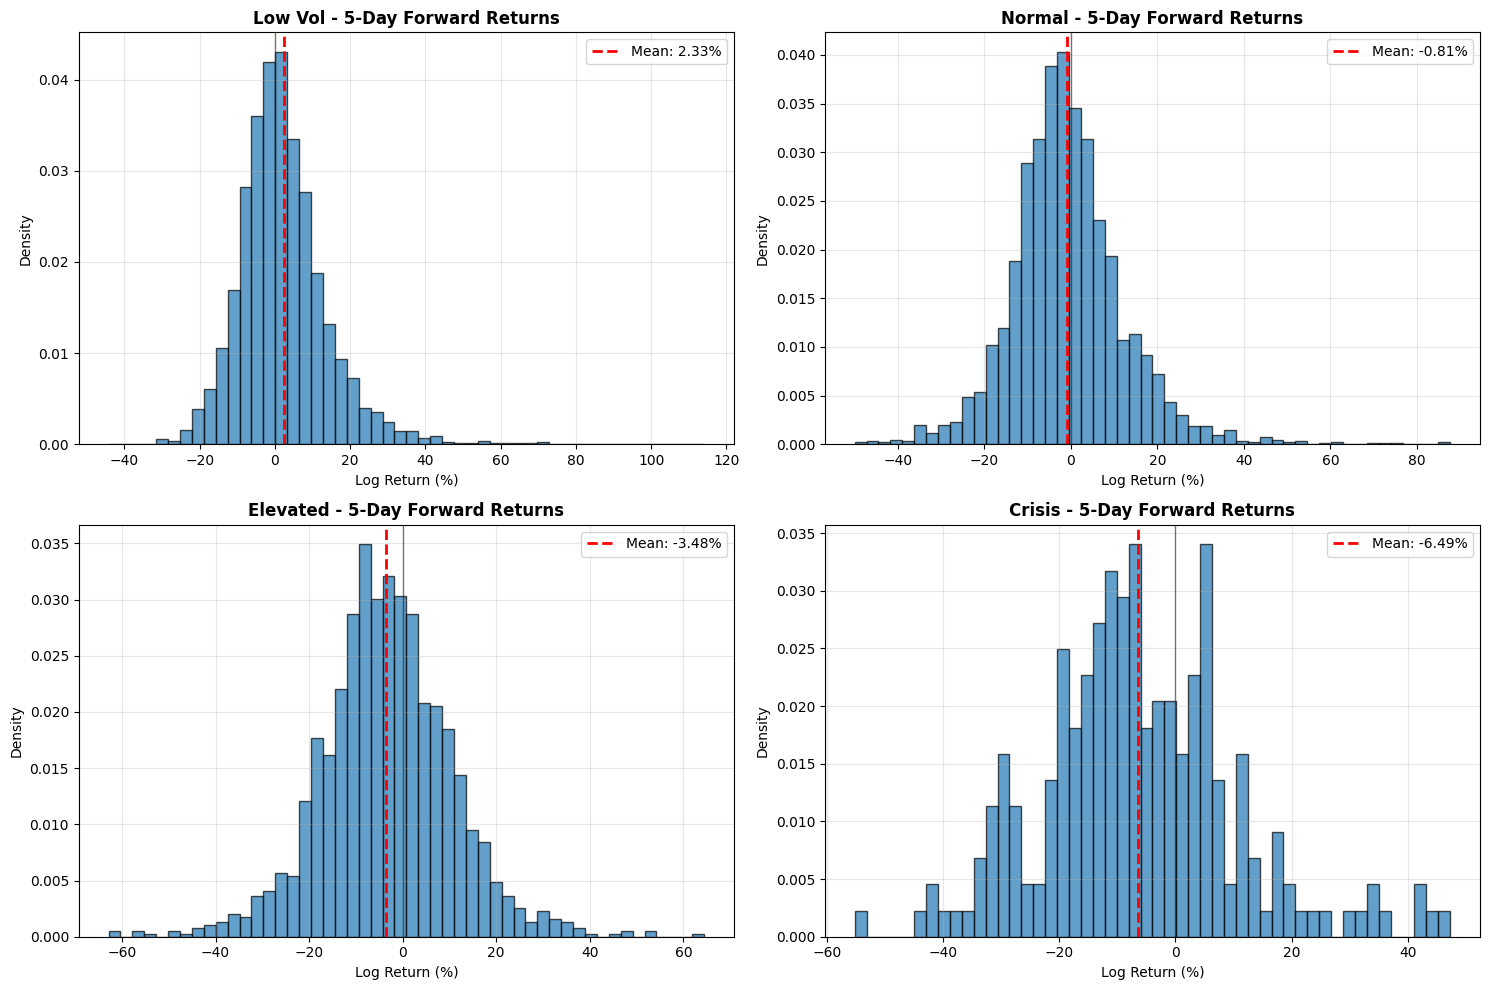


RECOMMENDED FEATURES FOR YOUR XGBOOST MODEL

REGIME-BASED FEATURES:
1. Current regime (categorical)
2. Days in current regime (persistence)
3. Distance to nearest regime boundary
4. VIX percentile rank within current regime
5. Regime transition probability (from transition matrix)

STATISTICAL FEATURES BY REGIME:
6. Rolling volatility of VIX (20d, calibrated by regime)
7. Mean reversion z-score within regime
8. Skewness of recent returns (5d, 20d) - varies by regime
9. Distance from regime mean/median

INTERACTION FEATURES:
10. Regime × Day-of-week
11. Regime × FOMC week indicator
12. Regime × OpEx week indicator
13. Regime × Earnings season indicator
14. Regime × Time-to-FOMC (days)

VOLATILITY CLUSTERING:
15. Vol-of-vol (20-day rolling std of daily VIX changes)
16. GARCH(1,1) conditional variance estimates by regime
17. High-low range percentile within regime

TERM STRUCTURE (if available):
18. VIX/VIX3M ratio
19. VIX/VIX6M ratio
20. Term structure slope change

MEAN REVERSION INDIC

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import yfinance as yf
from scipy import stats
from scipy.stats import skew, kurtosis

# Fetch VIX data
print("Fetching VIX data...")
vix_data = yf.download("^VIX", start="1990-01-01", end=datetime.today().strftime('%Y-%m-%d'))
vix = vix_data['Close'].squeeze().dropna()

# Calculate 5-day forward returns (your target)
vix_forward_5d = vix.shift(-5)
vix_return_5d = np.log(vix_forward_5d / vix) * 100  # log normalized % change

print("="*80)
print("REGIME-DEPENDENT STATISTICS FOR VIX")
print("="*80)

# Define regimes
def assign_regime(value):
    if value < 16.77:
        return 'Low Vol'
    elif value < 24.40:
        return 'Normal'
    elif value < 39.67:
        return 'Elevated'
    else:
        return 'Crisis'

vix_df = pd.DataFrame({
    'vix': vix,
    'regime': vix.apply(assign_regime),
    'forward_5d_return': vix_return_5d
})

# 1. REGIME TRANSITION PROBABILITIES
print("\n1. REGIME TRANSITION MATRIX (5-day forward)")
print("-"*80)
vix_df['regime_5d_ahead'] = vix_df['regime'].shift(-5)
transition_matrix = pd.crosstab(
    vix_df['regime'], 
    vix_df['regime_5d_ahead'], 
    normalize='index'
) * 100
print(transition_matrix.round(2))
print("\nInterpretation: Shows probability of moving from one regime to another in 5 days")

# 2. MEAN REVERSION BY REGIME
print("\n2. MEAN REVERSION STATISTICS BY REGIME")
print("-"*80)
for regime in ['Low Vol', 'Normal', 'Elevated', 'Crisis']:
    regime_data = vix_df[vix_df['regime'] == regime]['forward_5d_return'].dropna()
    if len(regime_data) > 0:
        print(f"\n{regime}:")
        print(f"  Mean 5d return: {regime_data.mean():.3f}%")
        print(f"  Median 5d return: {regime_data.median():.3f}%")
        print(f"  Std Dev: {regime_data.std():.3f}%")
        print(f"  % Positive: {(regime_data > 0).sum() / len(regime_data) * 100:.1f}%")
        print(f"  % Negative: {(regime_data < 0).sum() / len(regime_data) * 100:.1f}%")
        
        # Mean reversion indicator
        if regime_data.mean() < -1:
            print(f"  >> STRONG MEAN REVERSION (tends to decrease)")
        elif regime_data.mean() > 1:
            print(f"  >> MOMENTUM (tends to increase)")

# 3. VOLATILITY OF VOLATILITY (vol clustering)
print("\n3. VOLATILITY OF VOLATILITY BY REGIME")
print("-"*80)
vix_df['vix_pct_change'] = vix.pct_change() * 100
vix_df['vol_of_vol_20d'] = vix_df['vix_pct_change'].rolling(20).std()

for regime in ['Low Vol', 'Normal', 'Elevated', 'Crisis']:
    regime_vol = vix_df[vix_df['regime'] == regime]['vol_of_vol_20d'].dropna()
    if len(regime_vol) > 0:
        print(f"{regime}: Mean Vol-of-Vol = {regime_vol.mean():.2f}, Median = {regime_vol.median():.2f}")

# 4. DISTANCE FROM REGIME BOUNDARIES (key feature!)
print("\n4. DISTANCE FROM REGIME BOUNDARIES")
print("-"*80)
print("Feature idea: How close is VIX to transitioning to next regime?")

def distance_to_boundaries(value):
    boundaries = [16.77, 24.40, 39.67]
    distances = {
        'dist_to_normal': abs(value - 16.77),
        'dist_to_elevated': abs(value - 24.40),
        'dist_to_crisis': abs(value - 39.67),
        'min_boundary_dist': min(abs(value - b) for b in boundaries)
    }
    return distances

sample_vix = [12, 16, 20, 28, 45]
for v in sample_vix:
    dist = distance_to_boundaries(v)
    print(f"VIX={v}: Min distance to boundary = {dist['min_boundary_dist']:.2f}")

# 5. REGIME DURATION STATISTICS
print("\n5. REGIME PERSISTENCE (How long do regimes last?)")
print("-"*80)
vix_df['regime_change'] = vix_df['regime'] != vix_df['regime'].shift(1)
vix_df['regime_duration'] = vix_df.groupby((vix_df['regime_change']).cumsum()).cumcount() + 1

for regime in ['Low Vol', 'Normal', 'Elevated', 'Crisis']:
    # Get duration at regime exit points
    regime_exits = vix_df[(vix_df['regime'] == regime) & (vix_df['regime_change'].shift(-1) == True)]
    if len(regime_exits) > 0:
        durations = regime_exits['regime_duration']
        print(f"\n{regime}:")
        print(f"  Median duration: {durations.median():.0f} days")
        print(f"  Mean duration: {durations.mean():.0f} days")
        print(f"  Max duration: {durations.max():.0f} days")

# 6. SKEWNESS AND KURTOSIS BY REGIME
print("\n6. DISTRIBUTION CHARACTERISTICS BY REGIME")
print("-"*80)
for regime in ['Low Vol', 'Normal', 'Elevated', 'Crisis']:
    regime_returns = vix_df[vix_df['regime'] == regime]['forward_5d_return'].dropna()
    if len(regime_returns) > 10:
        print(f"\n{regime}:")
        print(f"  Skewness: {skew(regime_returns):.3f}")
        print(f"  Kurtosis: {kurtosis(regime_returns):.3f}")
        print(f"  95th percentile: {np.percentile(regime_returns, 95):.2f}%")
        print(f"  5th percentile: {np.percentile(regime_returns, 5):.2f}%")

# 7. VIX SPIKE PROBABILITY
print("\n7. VIX SPIKE ANALYSIS (>20% increase in 5 days)")
print("-"*80)
vix_df['spike'] = vix_df['forward_5d_return'] > 20
for regime in ['Low Vol', 'Normal', 'Elevated', 'Crisis']:
    regime_data = vix_df[vix_df['regime'] == regime]
    if len(regime_data) > 0:
        spike_prob = regime_data['spike'].sum() / len(regime_data) * 100
        print(f"{regime}: {spike_prob:.2f}% chance of >20% spike in next 5 days")

# 8. VIX TERM STRUCTURE FEATURES (if you have VIX futures data)
print("\n8. CONTANGO/BACKWARDATION INDICATORS")
print("-"*80)
print("Recommended features if you have VIX futures:")
print("  - VIX/VIX3M ratio (term structure slope)")
print("  - VIX/VVIX ratio (volatility of volatility)")
print("  - VIX percentile rank within current regime")

# 9. PERCENTILE RANK WITHIN REGIME
print("\n9. VIX PERCENTILE RANK WITHIN CURRENT REGIME")
print("-"*80)
for regime in ['Low Vol', 'Normal', 'Elevated', 'Crisis']:
    regime_vix = vix[vix_df['regime'] == regime]
    if len(regime_vix) > 0:
        print(f"\n{regime} range: {regime_vix.min():.2f} - {regime_vix.max():.2f}")
        print(f"  25th percentile: {regime_vix.quantile(0.25):.2f}")
        print(f"  75th percentile: {regime_vix.quantile(0.75):.2f}")
        print(f"  >> Feature: (current_vix - regime_min) / (regime_max - regime_min)")

# 10. AUTOCORRELATION BY REGIME
print("\n10. AUTOCORRELATION STRUCTURE BY REGIME")
print("-"*80)
for regime in ['Low Vol', 'Normal', 'Elevated', 'Crisis']:
    regime_returns = vix_df[vix_df['regime'] == regime]['vix_pct_change'].dropna()
    if len(regime_returns) > 20:
        acf_1 = regime_returns.autocorr(lag=1)
        acf_5 = regime_returns.autocorr(lag=5)
        print(f"{regime}: ACF(1)={acf_1:.3f}, ACF(5)={acf_5:.3f}")

# 11. REALIZED VOLATILITY VS IMPLIED (VIX)
print("\n11. REALIZED VS IMPLIED VOLATILITY GAP")
print("-"*80)
vix_df['realized_vol_20d'] = vix_df['vix_pct_change'].rolling(20).std() * np.sqrt(252)
vix_df['vix_premium'] = vix_df['vix'] - vix_df['realized_vol_20d']

for regime in ['Low Vol', 'Normal', 'Elevated', 'Crisis']:
    regime_premium = vix_df[vix_df['regime'] == regime]['vix_premium'].dropna()
    if len(regime_premium) > 0:
        print(f"{regime}: Mean VIX premium = {regime_premium.mean():.2f}")

# VISUALIZATION: Regime-dependent return distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
regimes = ['Low Vol', 'Normal', 'Elevated', 'Crisis']

for idx, (regime, ax) in enumerate(zip(regimes, axes.flatten())):
    regime_returns = vix_df[vix_df['regime'] == regime]['forward_5d_return'].dropna()
    
    if len(regime_returns) > 10:
        ax.hist(regime_returns, bins=50, alpha=0.7, edgecolor='black', density=True)
        ax.axvline(regime_returns.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {regime_returns.mean():.2f}%')
        ax.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
        ax.set_title(f'{regime} - 5-Day Forward Returns', fontsize=12, fontweight='bold')
        ax.set_xlabel('Log Return (%)')
        ax.set_ylabel('Density')
        ax.legend()
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# FEATURE ENGINEERING RECOMMENDATIONS
print("\n" + "="*80)
print("RECOMMENDED FEATURES FOR YOUR XGBOOST MODEL")
print("="*80)
print("""
REGIME-BASED FEATURES:
1. Current regime (categorical)
2. Days in current regime (persistence)
3. Distance to nearest regime boundary
4. VIX percentile rank within current regime
5. Regime transition probability (from transition matrix)

STATISTICAL FEATURES BY REGIME:
6. Rolling volatility of VIX (20d, calibrated by regime)
7. Mean reversion z-score within regime
8. Skewness of recent returns (5d, 20d) - varies by regime
9. Distance from regime mean/median

INTERACTION FEATURES:
10. Regime × Day-of-week
11. Regime × FOMC week indicator
12. Regime × OpEx week indicator
13. Regime × Earnings season indicator
14. Regime × Time-to-FOMC (days)

VOLATILITY CLUSTERING:
15. Vol-of-vol (20-day rolling std of daily VIX changes)
16. GARCH(1,1) conditional variance estimates by regime
17. High-low range percentile within regime

TERM STRUCTURE (if available):
18. VIX/VIX3M ratio
19. VIX/VIX6M ratio
20. Term structure slope change

MEAN REVERSION INDICATORS:
21. (VIX - regime MA) / regime StdDev
22. Days since regime peak/trough
23. Regime momentum (5d return within regime context)

CALENDAR ANOMALIES INTERACTED WITH REGIME:
24. Is Monday × Regime
25. Is Friday × Regime
26. Days to month-end × Regime
27. Quarter-end week × Regime
""")

print("\nKEY INSIGHT: Your model should learn that:")
print("  - Low Vol → High spike probability, mean reversion upward")
print("  - Crisis → High reversion probability, mean reversion downward")
print("  - Regime boundaries are sticky (clustering)")
print("  - Volatility clustering is regime-dependent")

In [34]:
from config import ENSEMBLE_CONFIG
act_thres =ENSEMBLE_CONFIG['actionable_threshold']
print(act_thres)

0.65


In [7]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
from config import ENSEMBLE_CONFIG
from core.prediction_database import PredictionDatabase

def analyze_signals():
    db=PredictionDatabase()
    df=db.get_predictions(with_actuals=True)
    
    if len(df)==0:
        print("No predictions in database")
        return
    
    cfg=ENSEMBLE_CONFIG
    thresholds=cfg["dynamic_thresholds"]
    min_threshold=min(thresholds['up']['low_magnitude'],thresholds['down']['low_magnitude'])
    
    print("="*80)
    print("📊 SIGNAL OVERVIEW:")
    print(f"   Total predictions: {len(db.get_predictions())}")
    
    actionable=df[df['direction_probability']>df['direction_probability'].quantile(min_threshold)]
    print(f"   Actionable: (≥{min_threshold:.2f} confidence): {len(actionable)} ({len(actionable)/len(df)*100:.1f}%)")
    
    print(f"\n🎯 ACTIONABLE SIGNAL BREAKDOWN:")
    print(f"   By Direction:")
    for direction in ['UP','DOWN']:
        count=len(actionable[actionable['direction_prediction']==direction])
        pct=count/len(actionable)*100 if len(actionable)>0 else 0
        print(f"      {direction:4s}: {count:4d} ({pct:.1f}%)")
    
    print(f"\n   By Cohort:")
    for cohort in actionable['calendar_cohort'].value_counts().index:
        count=len(actionable[actionable['calendar_cohort']==cohort])
        print(f"      {cohort:18s}: {count:4d}")
    
    print(f"\n   Confidence Distribution:")
    bins=[0.60,0.65,0.70,0.75,1.0]
    for i in range(len(bins)-1):
        count=len(actionable[(actionable['direction_probability']>=bins[i])&(actionable['direction_probability']<bins[i+1])])
        print(f"      {bins[i]*100:.0f}-{bins[i+1]*100:.0f}%    : {count:4d}")
    
    print(f"\n✅ ACTIONABLE SIGNAL PERFORMANCE:")
    with_actuals=actionable[actionable['actual_direction'].notna()]
    print(f"   Signals with actuals: {len(with_actuals)}")
    
    if len(with_actuals)>0:
        correct=(with_actuals['direction_prediction']==with_actuals['actual_direction'].map({1:'UP',0:'DOWN'}))
        print(f"   Direction accuracy: {correct.sum()/len(with_actuals)*100:.1f}%")
        
        mae=np.abs(with_actuals['magnitude_forecast']-with_actuals['actual_vix_change']).mean()
        print(f"   Magnitude MAE: {mae:.2f}%")
        
        for direction in ['UP','DOWN']:
            dir_df=with_actuals[with_actuals['direction_prediction']==direction]
            if len(dir_df)>0:
                actual_dir_map={1:'UP',0:'DOWN'}
                dir_correct=(dir_df['actual_direction'].map(actual_dir_map)==direction).sum()
                print(f"   {direction} signals accuracy: {dir_correct/len(dir_df)*100:.1f}% ({len(dir_df)} signals)")
    
    print("="*80)

if __name__=="__main__":
    analyze_signals()

📊 SIGNAL OVERVIEW:
   Total predictions: 345
   Actionable: (≥0.55 confidence): 153 (45.1%)

🎯 ACTIONABLE SIGNAL BREAKDOWN:
   By Direction:
      UP  :   72 (47.1%)
      DOWN:   81 (52.9%)

   By Cohort:
      fomc_period       :   90
      mid_cycle         :   33
      opex_week         :   23
      earnings_heavy    :    7

   Confidence Distribution:
      60-65%    :   33
      65-70%    :   48
      70-75%    :   17
      75-100%    :   27

✅ ACTIONABLE SIGNAL PERFORMANCE:
   Signals with actuals: 153
   Direction accuracy: 78.4%
   Magnitude MAE: 13.60%
   UP signals accuracy: 83.3% (72 signals)
   DOWN signals accuracy: 74.1% (81 signals)


In [1]:
# Database Signal Export Script - Execute from /src
# Exports predictions and actionable signals with comprehensive stats

import sqlite3
from datetime import datetime
from pathlib import Path
import pandas as pd
import numpy as np
from config import ENSEMBLE_CONFIG


def get_dynamic_threshold(magnitude_forecast):
    """Get dynamic threshold based on magnitude forecast"""
    thresholds = ENSEMBLE_CONFIG["dynamic_thresholds"]
    
    abs_mag = abs(magnitude_forecast) if pd.notna(magnitude_forecast) else 0
    
    # Determine if UP or DOWN based on sign
    if magnitude_forecast > 0:
        direction_thresholds = thresholds['up']
    else:
        direction_thresholds = thresholds['down']
    
    # Select threshold based on magnitude
    if abs_mag >= 12.0:
        return direction_thresholds['high_magnitude']
    elif abs_mag >= 6.0:
        return direction_thresholds['medium_magnitude']
    else:
        return direction_thresholds['low_magnitude']


def export_database_signals(db_path='data_cache/predictions.db', output_dir='diagnostics'):
    """Export all signals and actionable predictions from the database"""
    
    print("=" * 80)
    print("DATABASE SIGNAL EXPORT")
    print("=" * 80)
    
    db_path = Path(db_path)
    if not db_path.exists():
        print(f"❌ Database not found at {db_path}")
        return
    
    out = Path(output_dir)
    out.mkdir(exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    conn = sqlite3.connect(db_path)
    
    # Get all predictions from database
    query = """
    SELECT 
        prediction_id,
        timestamp,
        observation_date,
        forecast_date,
        horizon,
        calendar_cohort,
        cohort_weight,
        direction_prediction,
        direction_probability,
        magnitude_forecast,
        expected_vix,
        current_vix,
        feature_quality,
        num_features_used,
        actual_vix_change,
        actual_direction,
        direction_correct,
        magnitude_error,
        correction_type,
        model_version,
        created_at
    FROM forecasts 
    ORDER BY forecast_date DESC, observation_date DESC
    """
    
    all_data = pd.read_sql_query(query, conn)
    conn.close()
    
    # Add computed columns with dynamic thresholds
    if 'direction_probability' in all_data.columns:
        all_data['ensemble_confidence'] = all_data['direction_probability'].apply(
            lambda x: max(x, 1 - x) if pd.notna(x) else np.nan
        )
        
        # Apply dynamic threshold based on magnitude
        all_data['dynamic_threshold'] = all_data['magnitude_forecast'].apply(get_dynamic_threshold)
        all_data['actionable'] = (all_data['ensemble_confidence'] >= all_data['dynamic_threshold'])
    
    # ========================================================================
    # PRINT COMPREHENSIVE STATISTICS
    # ========================================================================
    
    print(f"\n📊 DATABASE CONTENTS:")
    print(f"   Total predictions: {len(all_data)}")
    print(f"   Date range: {all_data['forecast_date'].min()} to {all_data['forecast_date'].max()}")
    
    # Count predictions by direction
    up_total = (all_data['direction_prediction'] == 'UP').sum()
    down_total = (all_data['direction_prediction'] == 'DOWN').sum()
    print(f"\n   All Predictions by Direction:")
    print(f"      UP: {up_total} ({up_total/len(all_data)*100:.1f}%)")
    print(f"      DOWN: {down_total} ({down_total/len(all_data)*100:.1f}%)")
    
    # Actionable signal stats
    if 'actionable' in all_data.columns:
        actionable_only = all_data[all_data['actionable'] == True].copy()
        
        print(f"\n   Actionable Signals (dynamic thresholds):")
        print(f"      Total actionable: {len(actionable_only)} ({len(actionable_only)/len(all_data)*100:.1f}%)")
        print(f"      Threshold range: {actionable_only['dynamic_threshold'].min():.2f} to {actionable_only['dynamic_threshold'].max():.2f}")
        
        up_count = (actionable_only['direction_prediction'] == 'UP').sum()
        down_count = (actionable_only['direction_prediction'] == 'DOWN').sum()
        print(f"      UP signals: {up_count} ({up_count/len(actionable_only)*100:.1f}%)")
        print(f"      DOWN signals: {down_count} ({down_count/len(actionable_only)*100:.1f}%)")
    
    # Performance stats (all predictions with actuals)
    with_actuals = all_data[all_data['actual_vix_change'].notna()].copy()
    if len(with_actuals) > 0:
        print(f"\n   All Predictions Performance ({len(with_actuals)} with actuals):")
        
        if 'direction_correct' in with_actuals.columns:
            overall_acc = (with_actuals['direction_correct'] == 1).mean()
            print(f"      Overall direction accuracy: {overall_acc:.1%}")
            
            up_all = with_actuals[with_actuals['direction_prediction'] == 'UP']
            if len(up_all) > 0:
                up_acc = (up_all['direction_correct'] == 1).mean()
                print(f"      UP accuracy: {up_acc:.1%} ({len(up_all)} signals)")
            
            down_all = with_actuals[with_actuals['direction_prediction'] == 'DOWN']
            if len(down_all) > 0:
                down_acc = (down_all['direction_correct'] == 1).mean()
                print(f"      DOWN accuracy: {down_acc:.1%} ({len(down_all)} signals)")
        
        if 'magnitude_error' in with_actuals.columns:
            mae = with_actuals['magnitude_error'].mean()
            print(f"      Magnitude MAE: {mae:.2f}%")
    
    # Actionable performance stats
    if 'actionable' in all_data.columns and len(with_actuals) > 0:
        actionable_actuals = all_data[
            (all_data['actionable'] == True) & 
            (all_data['actual_vix_change'].notna())
        ].copy()
        
        if len(actionable_actuals) > 0:
            print(f"\n   Actionable Signals Performance ({len(actionable_actuals)} with actuals):")
            
            if 'direction_correct' in actionable_actuals.columns:
                overall_acc = (actionable_actuals['direction_correct'] == 1).mean()
                print(f"      Overall direction accuracy: {overall_acc:.1%}")
                
                up_actionable = actionable_actuals[actionable_actuals['direction_prediction'] == 'UP']
                if len(up_actionable) > 0:
                    up_acc = (up_actionable['direction_correct'] == 1).mean()
                    print(f"      UP accuracy: {up_acc:.1%} ({len(up_actionable)} signals)")
                
                down_actionable = actionable_actuals[actionable_actuals['direction_prediction'] == 'DOWN']
                if len(down_actionable) > 0:
                    down_acc = (down_actionable['direction_correct'] == 1).mean()
                    print(f"      DOWN accuracy: {down_acc:.1%} ({len(down_actionable)} signals)")
            
            if 'magnitude_error' in actionable_actuals.columns:
                mae = actionable_actuals['magnitude_error'].mean()
                print(f"      Magnitude MAE: {mae:.2f}%")
    
    # Cohort breakdown
    if 'actionable' in all_data.columns and len(actionable_only) > 0:
        print(f"\n   Actionable Signals by Cohort:")
        for cohort in actionable_only['calendar_cohort'].value_counts().index:
            count = (actionable_only['calendar_cohort'] == cohort).sum()
            pct = count / len(actionable_only) * 100
            print(f"      {cohort}: {count} ({pct:.1f}%)")
    
    # Confidence distribution
    if 'ensemble_confidence' in all_data.columns:
        print(f"\n   Confidence Distribution (all predictions):")
        bins = [0.0, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 1.0]
        for i in range(len(bins)-1):
            count = ((all_data['ensemble_confidence'] >= bins[i]) & 
                    (all_data['ensemble_confidence'] < bins[i+1])).sum()
            pct = count / len(all_data) * 100
            print(f"      {bins[i]:.2f}-{bins[i+1]:.2f}: {count} ({pct:.1f}%)")
    
    # ========================================================================
    # EXPORT SINGLE FILE
    # ========================================================================
    
    print("\n" + "=" * 80)
    print("EXPORTING DATA")
    print("=" * 80)
    
    # Export comprehensive CSV with all data
    export_path = out / f'predictions_export_{timestamp}.csv'
    all_data.to_csv(export_path, index=False)
    
    print(f"\n✅ Exported predictions database:")
    print(f"   File: {export_path}")
    print(f"   Records: {len(all_data)}")
    print(f"   Columns: {len(all_data.columns)}")
    
    print("\n" + "=" * 80)
    print("✅ EXPORT COMPLETE")
    print("=" * 80)
    
    print("\nKey columns in export:")
    print("  • actionable - Boolean flag for dynamic threshold")
    print("  • dynamic_threshold - Threshold used for this prediction")
    print("  • ensemble_confidence - Max(prob, 1-prob)")
    print("  • direction_prediction, direction_probability")
    print("  • magnitude_forecast, actual_vix_change")
    print("  • direction_correct, magnitude_error")
    
    return all_data


if __name__ == "__main__":
    results = export_database_signals()

DATABASE SIGNAL EXPORT

📊 DATABASE CONTENTS:
   Total predictions: 483
   Date range: 2024-01-07T00:00:00 to 2025-12-08T00:00:00

   All Predictions by Direction:
      UP: 202 (41.8%)
      DOWN: 281 (58.2%)

   Actionable Signals (dynamic thresholds):
      Total actionable: 243 (50.3%)
      Threshold range: 0.47 to 0.57
      UP signals: 202 (83.1%)
      DOWN signals: 41 (16.9%)

   All Predictions Performance (476 with actuals):
      Overall direction accuracy: 66.8%
      UP accuracy: 74.1% (201 signals)
      DOWN accuracy: 61.5% (275 signals)
      Magnitude MAE: 15.64%

   Actionable Signals Performance (239 with actuals):
      Overall direction accuracy: 73.6%
      UP accuracy: 74.1% (201 signals)
      DOWN accuracy: 71.1% (38 signals)
      Magnitude MAE: 14.51%

   Actionable Signals by Cohort:
      fomc_period: 152 (62.6%)
      mid_cycle: 43 (17.7%)
      opex_week: 36 (14.8%)
      earnings_heavy: 12 (4.9%)

   Confidence Distribution (all predictions):
      0.00-

Fetching ^SKEW data...

Successfully fetched 8975 data points
Date range: 1990-01-02 to 2025-12-04

Recent data:
Price            Close        High         Low        Open Volume
Ticker           ^SKEW       ^SKEW       ^SKEW       ^SKEW  ^SKEW
Date                                                             
2025-11-20  144.960007  144.960007  144.960007  144.960007      0
2025-11-21  148.339996  148.339996  148.339996  148.339996      0
2025-11-24  148.600006  148.600006  148.600006  148.600006      0
2025-11-25  151.679993  151.679993  151.679993  151.679993      0
2025-11-26  145.039993  145.039993  145.039993  145.039993      0
2025-11-28  143.000000  143.000000  143.000000  143.000000      0
2025-12-01  144.860001  144.860001  144.860001  144.860001      0
2025-12-02  144.940002  144.940002  144.940002  144.940002      0
2025-12-03  149.229996  149.229996  149.229996  149.229996      0
2025-12-04  148.910004  148.910004  148.910004  148.910004      0

Statistics:
Ticker        ^S

TypeError: unsupported format string passed to Series.__format__

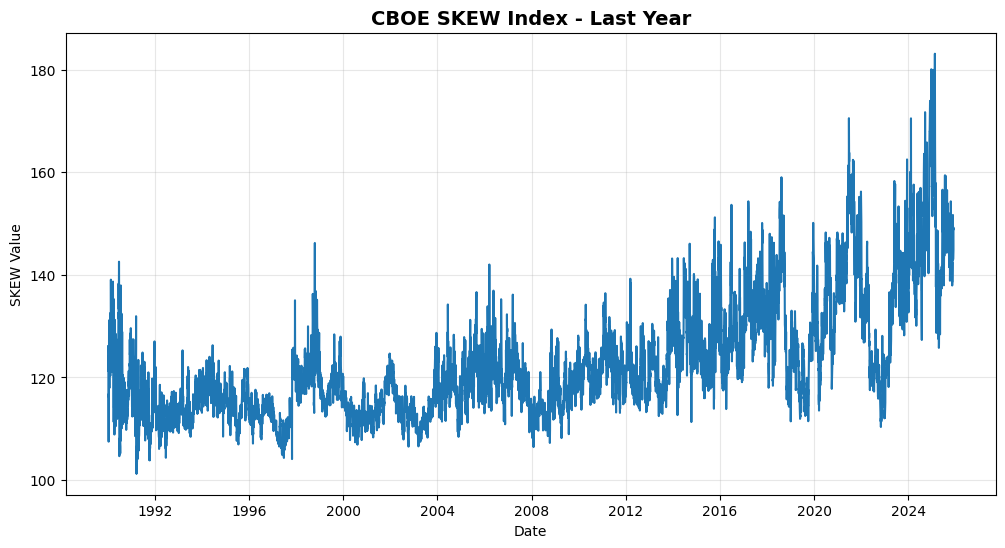

In [3]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Fetch CBOE SKEW Index
ticker = "^SKEW"
print(f"Fetching {ticker} data...\n")

# Download maximum historical data
skew = yf.download(ticker, period="max", progress=False)

print(f"Successfully fetched {len(skew)} data points")
print(f"Date range: {skew.index[0].date()} to {skew.index[-1].date()}\n")

# Display summary
print("Recent data:")
print(skew.tail(10))

print("\nStatistics:")
print(skew['Close'].describe())

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(skew.index, skew['Close'], linewidth=1.5)
plt.title('CBOE SKEW Index - Last Year', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('SKEW Value')
plt.grid(True, alpha=0.3)
plt.axhline(y=skew['Close'].mean(), color='r', linestyle='--', alpha=0.5, label=f'Mean: {skew["Close"].mean():.2f}')
plt.legend()
plt.tight_layout()
plt.show()

# Show current value
current_skew = skew['Close'].iloc[-1]
print(f"\nCurrent SKEW: {current_skew:.2f}")
print(f"Mean SKEW (1Y): {skew['Close'].mean():.2f}")
print(f"Min SKEW (1Y): {skew['Close'].min():.2f}")
print(f"Max SKEW (1Y): {skew['Close'].max():.2f}")